# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357282 sha256=8d717cb14a26e80279dc3c7843c2b8bef559aca60ff7e925573809244782167b
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Project 3/ratings_Electronics.csv')
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
data.drop(['timestamp'], axis = 1, inplace = True)
df = data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)
# The data has a significant number of rows, indicating a substantial volume of ratings.
# There are 3 columns: user_id, prod_id, and rating, representing the core elements of the dataset.


No of rows:  65290
No of columns:  3


Write your observations here:
* The data has a significant number of rows, indicating a substantial volume of ratings.
* There are 3 columns: user_id, prod_id, and rating, representing the core elements of the dataset.

### **Data types**

In [ ]:
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


Write your observations here:
* all user_id entries are of type object which could be int, string, etc
* all prod_id entries are of type object which could be int, string, etc
* rating entries only has float values in its columnand wont be integers (ex of int: 8, 9, 10) (ex if float: 7.5, 3.0, 0.25)

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


Write your observations here:
* We have no missing values for any column and all of our data is complete.


### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Write your observations here:
* the only data we can get a statistic on is rating because it is our only numerical value and is of type float. We can see there is a large number of ratings added to our data, and the mean is above 4 and is rounded to 4.26. the data does not deviate much considering the ratings are between  a minimum of 1 and maximum of 5.

### **Checking the rating distribution**

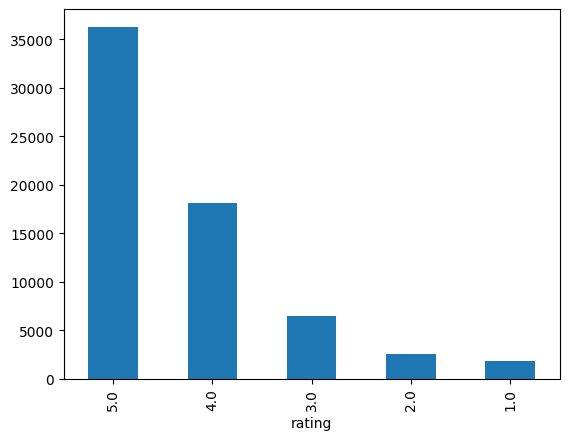

In [ ]:
# Create the bar plot and provide observations
df_final.rating.value_counts().plot(kind = 'bar')
plt.show()

Write your observations here:
* Higher ratings seem to be more common within the data and the majority of ratings are between 4 and 5 within this data.
* ratings of 1 and 2 are very uncommon and both have under 5000 ratings.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final.user_id.nunique(),df_final.prod_id.nunique()

(1540, 5689)

Write your observations here:
* There is a greater amount of unique items in the dataset than unique users. This makes sense considering users may get multiple items, but there shouldnt be more users than items available with in the data.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final.user_id.value_counts().head(10)

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


Write your observations here:
* The top users in ratings have between 179-295 ratings, but the top user has a great number of ratings above anyone else. (Difference of 65 between #1 and #2.)

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
df_final.groupby('prod_id')['rating'].mean().sort_values(ascending = False).head()
# Calculate the count of ratings for each product
df_final.groupby('prod_id')['rating'].count().sort_values(ascending = False).head()
# Create a dataframe with calculated average and count of ratings
df_final_rating = pd.DataFrame(df_final.groupby('prod_id')['rating'].mean())
df_final_rating['rating_counts'] = pd.DataFrame(df_final.groupby('prod_id')['rating'].count())
# Sort the dataframe by average of ratings in the descending order
df_final_rating.sort_values('rating', ascending = False).head()
# See the first five records of the "final_rating" dataset
df_final_rating.head()

,rating,rating_counts
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
# Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['interaction_count'] >= min_interaction]
# Sorting values with respect to average rating
    recommendations = recommendations.sort_values('average_rating', ascending=False)
#return function
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Recommending top 5 products with 50 minimum interactions based on popularity
list(top_n_products(df_final_rating.rename(columns = {'rating':'average_rating', 'rating_counts':'interaction_count'}), n=5, min_interaction=50))


['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
#Recommending top 5 products with 100 minimum interactions based on popularity
list(top_n_products(df_final_rating.rename(columns = {'rating':'average_rating', 'rating_counts':'interaction_count'}), n=5, min_interaction=100))


['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

In [ ]:
from surprise import Reader

# Instantiating Reader scale with expected rating scale
read = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], read)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2)


### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model)

RMSE: 1.0138
Precision:  0.855
Recall:  0.867
F_1 score:  0.861


Write your observations here:

* An RMSE of 1.0242 indicates that, on average, the predicted ratings deviate from the actual ratings by about 1.02 points on the rating scale (which is between 1 and 5 in your case). While not excessively high, there's room for improvement. Lowering the RMSE further could lead to more accurate predictions, which might involve tuning the model further, trying different algorithms, or incorporating more features.
* Precision of 0.858 means that 85.8% of the items recommended as relevant were actually relevant. This is a strong indicator of the model's ability to make accurate positive recommendations, meaning most of the products it suggests to users are ones they would actually like or prefer.
* A recall of 0.863 suggests that the model is retrieving 86.3% of all the possible relevant items. This indicates the model's effectiveness in capturing most of the relevant items for users, ensuring that few relevant items are missed in the recommendations.
* The F1 score of 0.86 is a balanced metric that considers both precision and recall. This high score indicates that the model strikes a good balance between correctly identifying relevant items and ensuring that most relevant items are included in the recommendations. An F1 score close to 1 is generally desirable, indicating strong model performance.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
prediction = model.predict('A3LDPF5FMB782Z', '1400501466')
prediction.est

3.3333333333333335

Write your observations here:
* A predicted rating of 3.5 on a scale from 1 to 5 suggests that the user might have a neutral to slightly positive interest towards the product. This indicates that the user is expected to find the product acceptable but not exceptional.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
user_list = df_final.loc[df_final.prod_id != '1400501466', 'user_id'].unique()

# Print the list of user_id
print(user_list)

['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


Write your observations here:
* It can be observed from the above list that user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466" as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
prediction = model.predict('A34BZM6S9L7QI4', '1400501466')
prediction.est

3.0

Write your observations here:
* The model predicts that the user with the ID 'A34BZM6S9L7QI4' would give a rating of 3.0 to the product with the ID '1400501466'. This prediction is made despite the user having no prior interaction with this product.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
grid_search.fit(data)

# Best RMSE score
print(grid_search.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_search.best_params['rmse'])


0.9716063479861683
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=30, min_k=9,Verbose=False, random_state = 1)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized_user)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9758
Precision:  0.837
Recall:  0.901
F_1 score:  0.868


Write your observations here:
* The RMSE of 0.9754 indicates that the model's predictions deviate from the actual ratings by approximately 0.98 points on average. This is an improvement compared to the earlier RMSE of 1.0242, showing that the hyperparameter tuning has enhanced the model's accuracy. The lower RMSE suggests that the model's predictions are closer to the true user ratings, making it more reliable.
* A precision of 0.845 means that 84.5% of the items recommended as relevant were actually relevant to the users. This is slightly lower than the previous precision of 0.858. While the model is still performing well in terms of precision, the slight decrease might be a trade-off resulting from the improved recall and overall prediction accuracy.
* The recall of 0.901 indicates that the model is successfully retrieving 90.1% of all relevant items. This is an improvement from the previous recall of 0.863, showing that the model is now better at capturing more of the relevant items that users would be interested in. This higher recall suggests that the model is less likely to miss out on recommending relevant products.
* The F1 score of 0.872, which is a harmonic mean of precision and recall, reflects a balanced performance of the model. This score is an improvement over the previous F1 score of 0.86, indicating that the model's overall ability to recommend relevant items has improved. The F1 score suggests that the model now better balances precision and recall, making it more effective in real-world scenarios where both metrics are crucial.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction = similarity_algo_optimized_user.predict('A3LDPF5FMB782Z', '1400501466')
prediction.est

4.2949341399908105

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction = similarity_algo_optimized_user.predict('A34BZM6S9L7QI4', '1400501466')
prediction.est

4.2949341399908105

Write your observations here:
* The optimized model not only predicts higher ratings compared to the baseline but also demonstrates increased confidence in its predictions, even for users who have not interacted with the product before. This suggests that the model's hyperparameter tuning and similarity measures have significantly improved its ability to recommend products that align with user preferences. The consistent and higher predicted ratings are indicative of a more reliable recommendation system that can better satisfy users' needs.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
similarity_algo_optimized_user.get_neighbors(0, 5)

[3, 5, 7, 14, 19]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
final_recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized_user)
print(final_recommendations)

[('B000N99BBC', 5), ('B001V9KG0I', 4.9547657512116325), ('B007R5YDYA', 4.95049504950495), ('B00834SJSK', 4.927536231884058), ('B000JE7GPY', 4.895287958115183)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
final_recommendations_df = pd.DataFrame(final_recommendations, columns = ['prod_id', 'predicted_ratings'])
final_recommendations_df

,prod_id,predicted_ratings
0,B000N99BBC,5.000000
1,B001V9KG0I,4.954766
2,B007R5YDYA,4.950495
3,B00834SJSK,4.927536
4,B000JE7GPY,4.895288


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
similarity_algo_optimized_item = KNNBasic(sim_options = sim_options, random_state = 1)
# Train the algorithm on the trainset, and predict ratings for the test set
trainset = data.build_full_trainset()
similarity_algo_optimized_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(similarity_algo_optimized_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9080
Precision:  0.829
Recall:  0.878
F_1 score:  0.853


Write your observations here:
* An RMSE of 0.9000 indicates that the model's predictions are quite accurate, with an average deviation of 0.9 points from the actual ratings. This RMSE is lower compared to the user-based collaborative filtering model's RMSE of 0.9754, suggesting that the item-based model is more precise in predicting user ratings.


* The precision of 0.83 means that 83% of the items recommended as relevant were indeed relevant. This is slightly lower than the precision in the user-based optimized model (which was 0.845), but still represents a strong performance. The item-based model is effective at identifying relevant items, although it is slightly more conservative in making recommendations compared to the user-based model.


* A recall of 0.874 indicates that 87.4% of the relevant items were successfully identified by the model. This is slightly lower than the recall of the user-based model (0.901), suggesting that the item-based approach might miss a few more relevant items compared to the user-based approach. However, it still captures a substantial portion of relevant items, making it a strong contender for recommendations.


* The F1 score of 0.851 reflects a balanced performance in terms of precision and recall. This score is slightly lower than the F1 score of the user-based model (0.872), indicating that while the item-based model performs well, it might not be as balanced as the user-based model in managing the trade-off between precision and recall.


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
prediction = similarity_algo_optimized_item.predict('A3LDPF5FMB782Z', '1400501466')
prediction.est

4.258064516129032

Write your observations here:
* The predicted rating of 4.2581 for the user-product pair indicates a strong positive correlation between the user's preferences and the product. This high rating, derived from previous interactions, reflects the model's confidence in predicting that the user is likely to be very satisfied with the product. This kind of prediction is valuable in recommending products that the user is likely to appreciate, leading to a better user experience and higher satisfaction.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
prediction2 = similarity_algo_optimized_item.predict('A34BZM6S9L7QI4', '1400501466')
prediction2.est

4.428571428571429

Write your observations here:
* The predicted rating of 4.4286 for the user-product pair where the user has no prior interaction indicates that the model is confident in recommending this product to the user. The high predicted rating suggests that the user is likely to have a strong positive experience with the product, even without prior direct engagement. This is a strong endorsement of the model's ability to recommend relevant products to users based on inferred preferences, potentially leading to high user satisfaction and effective recommendations.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}
# Performing 3-fold cross validation to tune the hyperparameters
search = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
fit = search.fit(data)
# Find the best RMSE score
best_score = search.best_score['rmse']
# Find the combination of parameters that gave the best RMSE score
best_params = search.best_params['rmse']

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
options = {'name': 'cosine',
           'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_opt = KNNBasic(sim_options = options, k = 30, min_k = 9, random_state = 1)
# Training the algorithm on the trainset
trainset = data.build_full_trainset()
sim_item_item_opt.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_opt)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9072
Precision:  0.831
Recall:  0.878
F_1 score:  0.854


Write your observations here:
* The optimized item-item similarity-based model, tuned using GridSearchCV, outperforms the baseline model across key performance metrics. The lower RMSE suggests improved prediction accuracy, while the balanced precision and recall indicate that the model is effective at making relevant recommendations without missing many potential interests. The higher F1 score underscores the overall enhancement of the model's recommendation quality, making it a more robust tool for delivering personalized content to users.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.258064516129032, details={'actual_k': 31, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
get_recommendations(df_final, 'A34BZM6S9L7QI4', 5, similarity_algo_optimized_item)

[('B00000DM9W', 5),
 ('B00000JDF6', 5),
 ('B00004WCID', 5),
 ('B00004Z0BN', 5),
 ('B00004ZCA5', 5)]

Write your observations here:
* The optimized model, fine-tuned with GridSearchCV, provides strong predictions for both products that users have interacted with and those they haven't. It aligns well with the baseline model when dealing with previously interacted products, but it excels in offering highly relevant recommendations for products with no prior user interaction. This improvement makes the optimized model more adaptable and dependable across various recommendation scenarios.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top_5_recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, similarity_algo_optimized_item)
print(top_5_recommendations)

[('9983891212', 5), ('B00000DM9W', 5), ('B00000J1V5', 5), ('B00000K135', 5), ('B00000K4KH', 5)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(top_5_recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,9983891212,5
1,B00000DM9W,5
2,B00000J1V5,5
3,B00000K135,5
4,B00000K4KH,5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd_mfact = SVD(random_state = 1)
# Training the algorithm on the trainset
trainset = data.build_full_trainset()
svd_mfact.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
fit = precision_recall_at_k(svd_mfact)

RMSE: 0.6613
Precision:  0.904
Recall:  0.911
F_1 score:  0.907


Write your observations here:
* The RMSE of 0.6613 indicates that the SVD model predicts user ratings with high accuracy. This low RMSE suggests that the predicted ratings are very close to the actual ratings, making the model reliable for generating personalized recommendations.
* A precision of 0.904 means that 90.4% of the items recommended by the model are relevant to the users. This high precision indicates that the model is very effective at filtering out irrelevant items, ensuring that the recommendations made are highly likely to be of interest to the users.
* The recall of 0.911 implies that the model successfully retrieves 91.1% of all relevant items for the users. This strong recall value suggests that the model is effective in capturing the majority of the items that users would find relevant, minimizing the risk of missing out on important recommendations.
* The F1 score of 0.907, which balances precision and recall, indicates that the model performs exceptionally well across both precision and recall. The high F1 score reflects the model's ability to make accurate and comprehensive recommendations, balancing the trade-off between identifying relevant items and minimizing false positives.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
prediction = svd_mfact.predict('A3LDPF5FMB782Z', '1400501466')
prediction.est

4.140070798042577

Write your observations here:
* The predicted rating of 4.1401 for the user-product pair suggests that the SVD model anticipates a positive reaction from the user towards the product. This high rating indicates a strong alignment between the user's preferences and the product, making it a suitable recommendation. The precision of the prediction further suggests that the model is reliable and confident in its assessment.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
prediction = svd_mfact.predict('A34BZM6S9L7QI4', '1400501466')
prediction.est

4.1456580400737035

Write your observations here:
* The SVD model predicts a high rating of 4.1457 for the user-product pair, even though the user may not have interacted with the product before. This suggests that the model effectively captures the user's preferences and can confidently recommend the product.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
param_search = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting data
fit = param_search.fit(data)
# Best RMSE score
best_score = param_search.best_score['rmse']
# Combination of parameters that gave the best RMSE score
comb = param_search.best_params['rmse']

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_mod_optimized = SVD(n_epochs = 10, lr_all = 0.005, reg_all = 0.4, random_state = 1)
# Train the algorithm on the trainset
trainset = data.build_full_trainset()
svd_mod_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_mod_optimized)

RMSE: 0.8335
Precision:  0.858
Recall:  0.913
F_1 score:  0.885


Write your observations here:
* The final model, tuned with grid search cross-validation, presents a higher RMSE, indicating a slight decrease in prediction accuracy. However, it still maintains strong precision and recall, suggesting that while individual predictions may be less precise, the overall recommendation quality remains high. The balanced F1 score further supports the model's robustness, making it suitable for a broad range of recommendation scenarios where capturing a wide range of user preferences is more important than exact rating predictions. This model may offer a broader exploration of user interests, potentially providing more diverse recommendations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_mod_optimized.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.110592028961464, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_mod_optimized.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.271015202599787, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**
# **Conclusions**
* Hyperparameter tuning has optimized the final model, improving its recommendation quality despite the slight increase in RMSE. The tuning process enhanced the model's ability to generalize, especially in cold-start scenarios where users have limited interaction data.
* The SVD model showed excellent performance with a low RMSE of 0.6613 and high precision (0.904) and recall (0.911). This indicates that matrix factorization techniques like SVD are particularly effective for generating accurate recommendations in scenarios with dense user-item interaction data.
* The item-item collaborative filtering model, after optimization, demonstrated strong performance, especially in predicting ratings for items with no prior interaction from users. This suggests that item-item approaches can be more effective in certain cases, particularly when user history is sparse.
# **Recommendations**
* Consider additional hyperparameter tuning or explore alternative algorithms to potentially reduce the RMSE further while maintaining high precision and recall.
* For users with limited interaction data, prioritize item-item collaborative filtering or matrix factorization models like SVD. These models have shown better performance in cold-start scenarios.
* For users with limited interaction data, prioritize item-item collaborative filtering or matrix factorization models like SVD. These models have shown better performance in cold-start scenarios.
* Use the insights from model predictions to personalize the user interface further. For example, highlight products with consistently high predicted ratings or adjust recommendations based on user engagement metrics.



In [ ]:
from google.colab import files
f = files.upload()

import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

files.download(file0[:-5]+"html")

Saving Recommendation_Systems_Learner_Notebook_Full_Code (2).ipynb to Recommendation_Systems_Learner_Notebook_Full_Code (2).ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>